In [1]:
%matplotlib inline
import xlrd
import numpy as np
import pandas as pd
from datetime import datetime, timedelta, date
import matplotlib.pyplot as plt
import seaborn as sns
import time
import os as os
from itertools import product
import scipy.stats as ss
from scipy.stats import norm
from sklearn.linear_model import LogisticRegression
np.set_printoptions(suppress=True, linewidth=200, edgeitems=100)

# Assumptions

Goal is to match up (approximately) VMware usage with instructors and their teaching. To do that we assume:

1. Academic Calendar is supposedly this way (could be different depending on academic year). This is the best partition based on the last five years:
- Fall: Aug 20 - Dec 25
- Winter: Jan 1 - Jan 26
- Spring: Jan 27 - May 23
- May: May 24 - June 30
- Summer: July 1 - Aug 19
2. Instructors log in to WMware durimg this time frame:
- no sooner than 30 mins before class time, and 
- no later than 30 mins after class.
3. Log ins are not close to midnight.

# Data Overview: usage_df (usage data) and soc_df (schedule of classes data)

Usage dataframe is provided, and soc dataframe is downloaded from the database.

In [4]:
usage_df = pd.read_csv('Desktops Usage Fall 2021.csv')
usage_df.head()

FileNotFoundError: [Errno 2] No such file or directory: 'Desktops Usage Fall 2021.csv'

In [74]:
usage_df.shape

(7058, 12)

In [75]:
print(usage_df.describe(include=['O']))

                                   MachineID Module        EventType  \
count                                   7058   7058             7058   
unique                                  6702      1                1   
top     dfffbccd-a22a-4212-a6c2-97c75ed6626a  Agent  AGENT_CONNECTED   
freq                                      22   7058             7058   

                                       ModuleAndEventText  Username     Time  \
count                                                7058      7058     7058   
unique                                               3677       485     6400   
top     User DEPAUW\dmaadmin has logged in to a new se...  cjnadmin  38:44.5   
freq                                                   17       347        3   

               DateTime                                    Source Severity  \
count              7058                                      7058     7058   
unique             6390                                         1        1   
top 

Make sure that all EventID's are unique so that we can use them as identifier.

In [76]:
usage_df['EventID'].astype(str).describe()

count      7058
unique     7058
top       99591
freq          1
Name: EventID, dtype: object

In [77]:
soc_df = pd.read_csv('SOC Space Usage.csv')
soc_df.head()

,COURSEOFFERING_ID,COURSE_ID,INST1_ID,INST2_ID,MEETING_DAY1,MEETING_DAY2,MEETING_DAY3,MEETING_DAY4,MEETING_DAY5,TIMESTART,TIMEEND,BUILDING1_CODE,BUILDING2_CODE,ROOM1,ROOM2,INST1_NAME,INST2_NAME,SEMESTER_CODE
0,130910,540,13548,NaN,T,R,NaN,NaN,NaN,10:00,11:30,ID,NaN,East Room,NaN,asuarez,NaN,2020202140
1,130913,2011,15061,NaN,M,W,F,NaN,NaN,10:20,11:20,ARR,NaN,NaN,NaN,salilbenegal,NaN,2020202140
2,130912,390,15350,NaN,T,R,NaN,NaN,NaN,11:40,1:10,ASC,NaN,Cinema 2,NaN,zacharymckenney,NaN,2020202140
3,130964,998,12269,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ARR,NaN,NaN,NaN,rmartoglio,NaN,2020202120
4,130963,700,12269,NaN,M,W,F,NaN,NaN,12:25,1:25,JSC,NaN,375,NaN,rmartoglio,NaN,2020202120


In [78]:
soc_df.shape

(3061, 18)

# Usage Data with Faculty only

Filter usage data by soc data. Only rows in usage dataframe having username that is either instructor 1's name or instructor 2's name in soc dataframe will be kept. 

In [81]:
username_series = pd.DataFrame(np.where((usage_df['Username'].isin(soc_df['INST1_NAME']) | 
usage_df['Username'].isin(soc_df['INST2_NAME'])),usage_df['Username'],None)).rename(columns = {0:'UsernameInst'})
usagenew_df = usage_df.join(username_series)
usageinst_df = usagenew_df.dropna(axis='rows',subset=['UsernameInst']).reset_index(drop=True)
usageinst_df.drop(['Time','MachineID','Module','EventType','ModuleAndEventText','Source','Severity','Acknowledged','Username'],axis='columns',inplace=True)
usageinst_df

,EventID,DateTime,Node,UsernameInst
0,1209,3/10/2021 17:29,ViewTest2-3.depauw.edu,veronicapejril
1,84756,8/4/2021 21:43,VDefaultD-4.depauw.edu,jliu
2,86974,8/9/2021 13:59,VDefaultD-3.depauw.edu,maria
3,88541,8/11/2021 8:37,VDefaultD-2.depauw.edu,naimashifa
4,92225,8/17/2021 15:32,VDefaultD-2.depauw.edu,cmcclellandmethvin
...,...,...,...,...
499,167778,10/8/2021 9:07,VDefaultD-9.depauw.edu,jennifereverett
500,168064,10/8/2021 11:36,V-AGD-1.depauw.edu,hpollack
501,168069,10/8/2021 11:36,VDefaultD-6.depauw.edu,aures
502,168164,10/8/2021 12:27,VDefaultD-12.depauw.edu,jacobhale


See how many logs-in from each instructor.

In [82]:
inst_freq_df = usageinst_df.groupby(['UsernameInst']).agg({'EventID':'count'})
inst_freq_df.rename(columns={'EventID':'Count'},inplace=True)
inst_freq_df.sort_values(by=['Count'],ascending=False)

,Count
UsernameInst,
jennifereverett,31
jacobhale,31
mrashid,29
hbarreto,28
grantskipper,27
...,...
mseaman,1
hpollack,1
jeannemcgill,1


# Usage Data Prepartion

Extract weekday from datetime and creat a new column named 'WeekDayFull'.

In [83]:
date_col = pd.to_datetime(usageinst_df['DateTime'])
weekday_col = pd.to_datetime(usageinst_df['DateTime']).dt.day_name()
time_col = pd.to_datetime(usageinst_df['DateTime']).dt.time
usageinst_df0 = usageinst_df.join(time_col.rename('Time'))
usageinst_df1 = usageinst_df0.join(date_col.rename('Date'))
usageinst_df2 = usageinst_df1.join(weekday_col.rename('WeekDayFull'))
usageinst_df2.drop(['DateTime'],axis='columns',inplace=True)
usageinst_df2

,EventID,Node,UsernameInst,Time,Date,WeekDayFull
0,1209,ViewTest2-3.depauw.edu,veronicapejril,17:29:00,2021-03-10 17:29:00,Wednesday
1,84756,VDefaultD-4.depauw.edu,jliu,21:43:00,2021-08-04 21:43:00,Wednesday
2,86974,VDefaultD-3.depauw.edu,maria,13:59:00,2021-08-09 13:59:00,Monday
3,88541,VDefaultD-2.depauw.edu,naimashifa,08:37:00,2021-08-11 08:37:00,Wednesday
4,92225,VDefaultD-2.depauw.edu,cmcclellandmethvin,15:32:00,2021-08-17 15:32:00,Tuesday
...,...,...,...,...,...,...
499,167778,VDefaultD-9.depauw.edu,jennifereverett,09:07:00,2021-10-08 09:07:00,Friday
500,168064,V-AGD-1.depauw.edu,hpollack,11:36:00,2021-10-08 11:36:00,Friday
501,168069,VDefaultD-6.depauw.edu,aures,11:36:00,2021-10-08 11:36:00,Friday
502,168164,VDefaultD-12.depauw.edu,jacobhale,12:27:00,2021-10-08 12:27:00,Friday


Convert the full weekday name (ex, Monday) to one-letter name (ex, M).

In [85]:
weekdayletter_col = pd.DataFrame(['M' if x == 'Monday' else 
                     'T' if x =='Tuesday' else
                     'W' if x == 'Wednesday' else
                     'R' if x == 'Thursday' else
                     'F' if x == 'Friday' else
                     'S' if x == 'Saturday' else
                     'U' for x in usageinst_df2['WeekDayFull']]).rename(columns = {0:'WeekDay'})
usageinst_df3 = usageinst_df2.join(weekdayletter_col)
usageinst_df3.drop(['WeekDayFull'],axis='columns',inplace=True)
usageinst_df3

,EventID,Node,UsernameInst,Time,Date,WeekDay
0,1209,ViewTest2-3.depauw.edu,veronicapejril,17:29:00,2021-03-10 17:29:00,W
1,84756,VDefaultD-4.depauw.edu,jliu,21:43:00,2021-08-04 21:43:00,W
2,86974,VDefaultD-3.depauw.edu,maria,13:59:00,2021-08-09 13:59:00,M
3,88541,VDefaultD-2.depauw.edu,naimashifa,08:37:00,2021-08-11 08:37:00,W
4,92225,VDefaultD-2.depauw.edu,cmcclellandmethvin,15:32:00,2021-08-17 15:32:00,T
...,...,...,...,...,...,...
499,167778,VDefaultD-9.depauw.edu,jennifereverett,09:07:00,2021-10-08 09:07:00,F
500,168064,V-AGD-1.depauw.edu,hpollack,11:36:00,2021-10-08 11:36:00,F
501,168069,VDefaultD-6.depauw.edu,aures,11:36:00,2021-10-08 11:36:00,F
502,168164,VDefaultD-12.depauw.edu,jacobhale,12:27:00,2021-10-08 12:27:00,F


Create semester code.

In [86]:
import datetime
semester_col = pd.DataFrame([str(x.year) + str(x.year + 1) + str(20) if datetime.datetime(x.year, 8, 20, 0, 0, 0) <= x <= datetime.datetime(x.year, 12, 25, 23, 59, 59) else
                            str(x.year - 1) + str(x.year) + str(30) if datetime.datetime(x.year, 1, 1, 0, 0, 0) <= x <= datetime.datetime(x.year, 1, 26, 23, 59, 59) else
                            str(x.year - 1) + str(x.year) + str(40) if datetime.datetime(x.year, 1, 27, 0, 0, 0) <= x <= datetime.datetime(x.year, 5, 23, 23, 59, 59) else 
                            str(x.year - 1) + str(x.year) + str(50) if datetime.datetime(x.year, 5, 24, 0, 0, 0) <= x <= datetime.datetime(x.year, 6, 30, 23, 59, 59) else 
                            str(x.year) + str(x.year + 1) + str(10) if datetime.datetime(x.year, 7, 1, 0, 0, 0) <= x <= datetime.datetime(x.year, 8, 19, 23, 59, 59) else 
                             None for x in usageinst_df3['Date']]).rename(columns = {0:'SEMESTER_STRCODE'})
usageinst_df4 = usageinst_df3.join(semester_col)
usageinst_df4

,EventID,Node,UsernameInst,Time,Date,WeekDay,SEMESTER_STRCODE
0,1209,ViewTest2-3.depauw.edu,veronicapejril,17:29:00,2021-03-10 17:29:00,W,2020202140
1,84756,VDefaultD-4.depauw.edu,jliu,21:43:00,2021-08-04 21:43:00,W,2021202210
2,86974,VDefaultD-3.depauw.edu,maria,13:59:00,2021-08-09 13:59:00,M,2021202210
3,88541,VDefaultD-2.depauw.edu,naimashifa,08:37:00,2021-08-11 08:37:00,W,2021202210
4,92225,VDefaultD-2.depauw.edu,cmcclellandmethvin,15:32:00,2021-08-17 15:32:00,T,2021202210
...,...,...,...,...,...,...,...
499,167778,VDefaultD-9.depauw.edu,jennifereverett,09:07:00,2021-10-08 09:07:00,F,2021202220
500,168064,V-AGD-1.depauw.edu,hpollack,11:36:00,2021-10-08 11:36:00,F,2021202220
501,168069,VDefaultD-6.depauw.edu,aures,11:36:00,2021-10-08 11:36:00,F,2021202220
502,168164,VDefaultD-12.depauw.edu,jacobhale,12:27:00,2021-10-08 12:27:00,F,2021202220


Create pseudotime, which is basically time in the time column but belongs to today's date. This is to compare times later, because datetime library can only compare times that are in a certain day, month and year.

In [87]:
from datetime import datetime, date
pseudotime_df = pd.DataFrame([datetime.combine(date.today(), x) for x in usageinst_df4['Time']])
pseudotime_df.rename(columns={0:'Pseudotime'},inplace=True)
usageinst_df5 = usageinst_df4.join(pseudotime_df)
usageinst_df5

,EventID,Node,UsernameInst,Time,Date,WeekDay,SEMESTER_STRCODE,Pseudotime
0,1209,ViewTest2-3.depauw.edu,veronicapejril,17:29:00,2021-03-10 17:29:00,W,2020202140,2021-11-23 17:29:00
1,84756,VDefaultD-4.depauw.edu,jliu,21:43:00,2021-08-04 21:43:00,W,2021202210,2021-11-23 21:43:00
2,86974,VDefaultD-3.depauw.edu,maria,13:59:00,2021-08-09 13:59:00,M,2021202210,2021-11-23 13:59:00
3,88541,VDefaultD-2.depauw.edu,naimashifa,08:37:00,2021-08-11 08:37:00,W,2021202210,2021-11-23 08:37:00
4,92225,VDefaultD-2.depauw.edu,cmcclellandmethvin,15:32:00,2021-08-17 15:32:00,T,2021202210,2021-11-23 15:32:00
...,...,...,...,...,...,...,...,...
499,167778,VDefaultD-9.depauw.edu,jennifereverett,09:07:00,2021-10-08 09:07:00,F,2021202220,2021-11-23 09:07:00
500,168064,V-AGD-1.depauw.edu,hpollack,11:36:00,2021-10-08 11:36:00,F,2021202220,2021-11-23 11:36:00
501,168069,VDefaultD-6.depauw.edu,aures,11:36:00,2021-10-08 11:36:00,F,2021202220,2021-11-23 11:36:00
502,168164,VDefaultD-12.depauw.edu,jacobhale,12:27:00,2021-10-08 12:27:00,F,2021202220,2021-11-23 12:27:00


Now we have instructor's username, semester code, weekday and pseudotime in usage dataframe that are ready to be matched up with data in soc dataframe.

# Schedule of Classes Data Preparation

Drop NaN time rows. Convert timestart (ex, 7:00 PM) and timeend (ex, 8:00 PM) to datetimes. Name these two newly created columns as 'TIMESTARTCV' and 'TIMEENDCV'. Python is smart enough to recognize the PM's there and convert them to 24-hour format. Also convert semester code to strings.

In [91]:
soc_df1 = soc_df.dropna(axis='rows',subset=['TIMESTART','TIMEEND']).reset_index(drop=True)
timestartcv_col = pd.to_datetime(soc_df1['TIMESTART'])
timeendcv_col = pd.to_datetime(soc_df1['TIMEEND'])
soc_df2_v1 = soc_df1.join(timestartcv_col.rename('TIMESTARTCV'))
soc_df2 = soc_df2_v1.join(timeendcv_col.rename('TIMEENDCV'))
soc_df2['SEMESTER_STRCODE'] = soc_df2['SEMESTER_CODE'].astype(str)
soc_df2.drop(['SEMESTER_CODE'],axis='columns',inplace=True)
soc_df2

,COURSEOFFERING_ID,COURSE_ID,INST1_ID,INST2_ID,MEETING_DAY1,MEETING_DAY2,MEETING_DAY3,MEETING_DAY4,MEETING_DAY5,TIMESTART,TIMEEND,BUILDING1_CODE,BUILDING2_CODE,ROOM1,ROOM2,INST1_NAME,INST2_NAME,TIMESTARTCV,TIMEENDCV,SEMESTER_STRCODE
0,130910,540,13548,NaN,T,R,NaN,NaN,NaN,10:00,11:30,ID,NaN,East Room,NaN,asuarez,NaN,2021-11-23 10:00:00,2021-11-23 11:30:00,2020202140
1,130913,2011,15061,NaN,M,W,F,NaN,NaN,10:20,11:20,ARR,NaN,NaN,NaN,salilbenegal,NaN,2021-11-23 10:20:00,2021-11-23 11:20:00,2020202140
2,130912,390,15350,NaN,T,R,NaN,NaN,NaN,11:40,1:10,ASC,NaN,Cinema 2,NaN,zacharymckenney,NaN,2021-11-23 11:40:00,2021-11-23 01:10:00,2020202140
3,130963,700,12269,NaN,M,W,F,NaN,NaN,12:25,1:25,JSC,NaN,375,NaN,rmartoglio,NaN,2021-11-23 12:25:00,2021-11-23 01:25:00,2020202120
4,130965,1333,12269,NaN,M,W,NaN,NaN,NaN,1:40,2:40,ARR,NaN,NaN,NaN,rmartoglio,NaN,2021-11-23 01:40:00,2021-11-23 02:40:00,2020202120
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2196,141343,580,14061,NaN,M,W,F,NaN,NaN,8:00,9:00,OL,NaN,AUD,NaN,lynnbedard,NaN,2021-11-23 08:00:00,2021-11-23 09:00:00,2021202240
2197,141344,581,14061,NaN,T,NaN,NaN,NaN,NaN,8:30,11:20,OL,NaN,142,NaN,lynnbedard,NaN,2021-11-23 08:30:00,2021-11-23 11:20:00,2021202240
2198,137805,1988,14609,NaN,T,R,NaN,NaN,NaN,2:20,3:50,PELR,NaN,103,NaN,rachelgoldberg,NaN,2021-11-23 02:20:00,2021-11-23 03:50:00,2021202240
2199,141363,617,12256,NaN,T,R,NaN,NaN,NaN,10:00,10:50,GCPA,NaN,1021,NaN,spiegelberg,NaN,2021-11-23 10:00:00,2021-11-23 10:50:00,2021202240


For times that are recorded as in between 1:00 and 7:00, they should actually be 13:00 PM and 19:00 PM. So add 12 hours to these values. Put them in two newly created columns named 'TIMESTARTCONV' and 'TIMEENDCOV'.

In [92]:
import datetime
timestartcv1 = pd.DataFrame([timedelta(hours=12) + x if datetime.datetime(x.year, x.month, x.day, 1, 0, 0) <= x <= datetime.datetime(x.year, x.month, x.day, 7, 0, 0)
 else x for x in soc_df2['TIMESTARTCV']])
timestartcv2 = pd.DataFrame(timestartcv1[0].dt.time)
timestartcv2.rename(columns={0:'TIMESTARTCONV'},inplace=True)
timeendcv1 = pd.DataFrame([timedelta(hours=12) + x if datetime.datetime(x.year, x.month, x.day, 1, 0, 0) <= x <= datetime.datetime(x.year, x.month, x.day, 7, 0, 0)
 else x for x in soc_df2['TIMEENDCV']])
timeendcv2 = pd.DataFrame(timeendcv1[0].dt.time)
timeendcv2.rename(columns={0:'TIMEENDCONV'},inplace=True)
soc_df3 = soc_df2.join(timestartcv2)
soc_df4 = soc_df3.join(timeendcv2)
soc_df4.drop(['TIMESTARTCV','TIMEENDCV'],axis='columns',inplace=True)
soc_df4

,COURSEOFFERING_ID,COURSE_ID,INST1_ID,INST2_ID,MEETING_DAY1,MEETING_DAY2,MEETING_DAY3,MEETING_DAY4,MEETING_DAY5,TIMESTART,TIMEEND,BUILDING1_CODE,BUILDING2_CODE,ROOM1,ROOM2,INST1_NAME,INST2_NAME,SEMESTER_STRCODE,TIMESTARTCONV,TIMEENDCONV
0,130910,540,13548,NaN,T,R,NaN,NaN,NaN,10:00,11:30,ID,NaN,East Room,NaN,asuarez,NaN,2020202140,10:00:00,11:30:00
1,130913,2011,15061,NaN,M,W,F,NaN,NaN,10:20,11:20,ARR,NaN,NaN,NaN,salilbenegal,NaN,2020202140,10:20:00,11:20:00
2,130912,390,15350,NaN,T,R,NaN,NaN,NaN,11:40,1:10,ASC,NaN,Cinema 2,NaN,zacharymckenney,NaN,2020202140,11:40:00,13:10:00
3,130963,700,12269,NaN,M,W,F,NaN,NaN,12:25,1:25,JSC,NaN,375,NaN,rmartoglio,NaN,2020202120,12:25:00,13:25:00
4,130965,1333,12269,NaN,M,W,NaN,NaN,NaN,1:40,2:40,ARR,NaN,NaN,NaN,rmartoglio,NaN,2020202120,13:40:00,14:40:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2196,141343,580,14061,NaN,M,W,F,NaN,NaN,8:00,9:00,OL,NaN,AUD,NaN,lynnbedard,NaN,2021202240,08:00:00,09:00:00
2197,141344,581,14061,NaN,T,NaN,NaN,NaN,NaN,8:30,11:20,OL,NaN,142,NaN,lynnbedard,NaN,2021202240,08:30:00,11:20:00
2198,137805,1988,14609,NaN,T,R,NaN,NaN,NaN,2:20,3:50,PELR,NaN,103,NaN,rachelgoldberg,NaN,2021202240,14:20:00,15:50:00
2199,141363,617,12256,NaN,T,R,NaN,NaN,NaN,10:00,10:50,GCPA,NaN,1021,NaN,spiegelberg,NaN,2021202240,10:00:00,10:50:00


Convert timestart converted and timeend converted to pseudotimes, just like what we did with usage data.

In [94]:
from datetime import datetime, date
pseudotimestart_df = pd.DataFrame([datetime.combine(date.today(), x) for x in soc_df4['TIMESTARTCONV']])
pseudotimestart_df.rename(columns={0:'Pseudotimestart'},inplace=True)
pseudotimeend_df = pd.DataFrame([datetime.combine(date.today(), x) for x in soc_df4['TIMEENDCONV']])
pseudotimeend_df.rename(columns={0:'Pseudotimeend'},inplace=True)
soc_df4_v1 = soc_df4.join(pseudotimestart_df)
soc_df5 = soc_df4_v1.join(pseudotimeend_df)
soc_df5.drop(['TIMESTARTCONV','TIMEENDCONV','MEETING_DAY4','MEETING_DAY5'],axis='columns',inplace=True)
soc_df5

,COURSEOFFERING_ID,COURSE_ID,INST1_ID,INST2_ID,MEETING_DAY1,MEETING_DAY2,MEETING_DAY3,TIMESTART,TIMEEND,BUILDING1_CODE,BUILDING2_CODE,ROOM1,ROOM2,INST1_NAME,INST2_NAME,SEMESTER_STRCODE,Pseudotimestart,Pseudotimeend
0,130910,540,13548,NaN,T,R,NaN,10:00,11:30,ID,NaN,East Room,NaN,asuarez,NaN,2020202140,2021-11-23 10:00:00,2021-11-23 11:30:00
1,130913,2011,15061,NaN,M,W,F,10:20,11:20,ARR,NaN,NaN,NaN,salilbenegal,NaN,2020202140,2021-11-23 10:20:00,2021-11-23 11:20:00
2,130912,390,15350,NaN,T,R,NaN,11:40,1:10,ASC,NaN,Cinema 2,NaN,zacharymckenney,NaN,2020202140,2021-11-23 11:40:00,2021-11-23 13:10:00
3,130963,700,12269,NaN,M,W,F,12:25,1:25,JSC,NaN,375,NaN,rmartoglio,NaN,2020202120,2021-11-23 12:25:00,2021-11-23 13:25:00
4,130965,1333,12269,NaN,M,W,NaN,1:40,2:40,ARR,NaN,NaN,NaN,rmartoglio,NaN,2020202120,2021-11-23 13:40:00,2021-11-23 14:40:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2196,141343,580,14061,NaN,M,W,F,8:00,9:00,OL,NaN,AUD,NaN,lynnbedard,NaN,2021202240,2021-11-23 08:00:00,2021-11-23 09:00:00
2197,141344,581,14061,NaN,T,NaN,NaN,8:30,11:20,OL,NaN,142,NaN,lynnbedard,NaN,2021202240,2021-11-23 08:30:00,2021-11-23 11:20:00
2198,137805,1988,14609,NaN,T,R,NaN,2:20,3:50,PELR,NaN,103,NaN,rachelgoldberg,NaN,2021202240,2021-11-23 14:20:00,2021-11-23 15:50:00
2199,141363,617,12256,NaN,T,R,NaN,10:00,10:50,GCPA,NaN,1021,NaN,spiegelberg,NaN,2021202240,2021-11-23 10:00:00,2021-11-23 10:50:00


In [95]:
from datetime import datetime, date
pseudotimestart_df = pd.DataFrame([datetime.combine(date.today(), x) for x in soc_df4['TIMESTARTCONV']])
pseudotimestart_df.rename(columns={0:'Pseudotimestart'},inplace=True)
pseudotimeend_df = pd.DataFrame([datetime.combine(date.today(), x) for x in soc_df4['TIMEENDCONV']])
pseudotimeend_df.rename(columns={0:'Pseudotimeend'},inplace=True)
soc_df4_v1 = soc_df4.join(pseudotimestart_df)
soc_df5 = soc_df4_v1.join(pseudotimeend_df)
soc_df5.drop(['TIMESTARTCONV','TIMEENDCONV','MEETING_DAY4','MEETING_DAY5'],axis='columns',inplace=True)
soc_df5

,COURSEOFFERING_ID,COURSE_ID,INST1_ID,INST2_ID,MEETING_DAY1,MEETING_DAY2,MEETING_DAY3,TIMESTART,TIMEEND,BUILDING1_CODE,BUILDING2_CODE,ROOM1,ROOM2,INST1_NAME,INST2_NAME,SEMESTER_STRCODE,Pseudotimestart,Pseudotimeend
0,130910,540,13548,NaN,T,R,NaN,10:00,11:30,ID,NaN,East Room,NaN,asuarez,NaN,2020202140,2021-11-23 10:00:00,2021-11-23 11:30:00
1,130913,2011,15061,NaN,M,W,F,10:20,11:20,ARR,NaN,NaN,NaN,salilbenegal,NaN,2020202140,2021-11-23 10:20:00,2021-11-23 11:20:00
2,130912,390,15350,NaN,T,R,NaN,11:40,1:10,ASC,NaN,Cinema 2,NaN,zacharymckenney,NaN,2020202140,2021-11-23 11:40:00,2021-11-23 13:10:00
3,130963,700,12269,NaN,M,W,F,12:25,1:25,JSC,NaN,375,NaN,rmartoglio,NaN,2020202120,2021-11-23 12:25:00,2021-11-23 13:25:00
4,130965,1333,12269,NaN,M,W,NaN,1:40,2:40,ARR,NaN,NaN,NaN,rmartoglio,NaN,2020202120,2021-11-23 13:40:00,2021-11-23 14:40:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2196,141343,580,14061,NaN,M,W,F,8:00,9:00,OL,NaN,AUD,NaN,lynnbedard,NaN,2021202240,2021-11-23 08:00:00,2021-11-23 09:00:00
2197,141344,581,14061,NaN,T,NaN,NaN,8:30,11:20,OL,NaN,142,NaN,lynnbedard,NaN,2021202240,2021-11-23 08:30:00,2021-11-23 11:20:00
2198,137805,1988,14609,NaN,T,R,NaN,2:20,3:50,PELR,NaN,103,NaN,rachelgoldberg,NaN,2021202240,2021-11-23 14:20:00,2021-11-23 15:50:00
2199,141363,617,12256,NaN,T,R,NaN,10:00,10:50,GCPA,NaN,1021,NaN,spiegelberg,NaN,2021202240,2021-11-23 10:00:00,2021-11-23 10:50:00


# Matching Up

## Method
First, join usage data and soc data by instructor's username and semestercode. The result is going to be one username and one semester code being matched with multiple offering classes. Reduce these classes to those that match week day. 

Next, further classify those classes by creating seven checkpoints:
- Checkpoint 1: classes that contain log-in times inside them. Drop duplicate. Put the rest to checkpoint 2.
- Checkpoint 2: Classes that contain log-in times from 5 minutes before to 5 minutes after classtime. Drop duplicates. Put the rest to checkpoint 3.
- Checkpoint 3: Classes that contain log-in times from 10 minutes before to 10 minutes after classtime. Drop duplicates. Put the rest to checkpoint 4.
- Checkpoint 4: Classes that contain log-in times from 15 minutes before to 15 minutes after classtime. Drop duplicates. Put the rest to checkpoint 5.
- Checkpoint 5: Classes that contain log-in times from 20 minutes before to 20 minutes after classtime. Drop duplicates. Put the rest to checkpoint 6.
- Checkpoint 6: Classes that contain log-in times from 25 minutes before to 25 minutes after classtime. Drop duplicates. Put the rest to checkpoint 7.
- Checkpoint 7: Classes that contain log-in times from 30 minutes before to 30 minutes after classtime. Drop duplicates. The rest of the data is disregarded.

Our final step is just to concatenate these seven results to a single dataframe.

This method is extremely faster than using for loop over all rows of a dataframe, because it takes advantage of pandas' "list comprehension", pandas' "join", "merge", and "concat" functions, and numpy's "where" function, which are all standardized and super efficient functions built in Python. We can also learn a bit about instructors' habit of logging in to VMware from this method (for example, if instructors prefer to log in VMware inside their classtime, or much sooner/later). 

## Join by username and semester code

In [97]:
df = soc_df5
tb = usageinst_df5

In [99]:
a = tb.merge(df,how='outer',left_on=['UsernameInst','SEMESTER_STRCODE'],right_on=['INST1_NAME','SEMESTER_STRCODE'])
a1 = a.dropna(axis='rows',subset=['EventID','COURSEOFFERING_ID']).reset_index(drop=True)
b = tb.merge(df,how='outer',left_on=['UsernameInst','SEMESTER_STRCODE'],right_on=['INST2_NAME','SEMESTER_STRCODE'])
b1 = b.dropna(axis='rows',subset=['EventID','COURSEOFFERING_ID']).reset_index(drop=True)
c = pd.concat([a1,b1]).reset_index(drop=True)
c

,EventID,Node,UsernameInst,Time,Date,WeekDay,SEMESTER_STRCODE,Pseudotime,COURSEOFFERING_ID,COURSE_ID,...,TIMESTART,TIMEEND,BUILDING1_CODE,BUILDING2_CODE,ROOM1,ROOM2,INST1_NAME,INST2_NAME,Pseudotimestart,Pseudotimeend
0,1209.0,ViewTest2-3.depauw.edu,veronicapejril,17:29:00,2021-03-10 17:29:00,W,2020202140,2021-11-23 17:29:00,129924.0,985.0,...,8:00,8:50,ARR,NaN,NaN,NaN,veronicapejril,NaN,2021-11-23 08:00:00,2021-11-23 08:50:00
1,94822.0,VDefaultD-3.depauw.edu,aldrinmagaya,16:28:00,2021-08-21 16:28:00,S,2021202220,2021-11-23 16:28:00,135548.0,1059.0,...,8:00,9:00,Tent 1,NaN,The Inn at DePauw,NaN,aldrinmagaya,NaN,2021-11-23 08:00:00,2021-11-23 09:00:00
2,94822.0,VDefaultD-3.depauw.edu,aldrinmagaya,16:28:00,2021-08-21 16:28:00,S,2021202220,2021-11-23 16:28:00,137947.0,2269.0,...,12:30,1:30,JSC,NaN,156,NaN,aldrinmagaya,NaN,2021-11-23 12:30:00,2021-11-23 13:30:00
3,94822.0,VDefaultD-3.depauw.edu,aldrinmagaya,16:28:00,2021-08-21 16:28:00,S,2021202220,2021-11-23 16:28:00,138103.0,153.0,...,1:40,2:40,JSC,NaN,156,NaN,aldrinmagaya,NaN,2021-11-23 13:40:00,2021-11-23 14:40:00
4,95130.0,VDefaultD-2.depauw.edu,cklaus,09:01:00,2021-08-23 09:01:00,M,2021202220,2021-11-23 09:01:00,135988.0,2208.0,...,2:50,3:50,EC,NaN,108,NaN,cklaus,NaN,2021-11-23 14:50:00,2021-11-23 15:50:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1316,153120.0,VDefaultD-1.depauw.edu,leigh-annegoins,19:26:00,2021-09-28 19:26:00,T,2021202220,2021-11-23 19:26:00,135749.0,1667.0,...,7:00 PM,8:30 PM,AH,NaN,17,NaN,leigh-annegoins,NaN,2021-11-23 19:00:00,2021-11-23 20:30:00
1317,168064.0,V-AGD-1.depauw.edu,hpollack,11:36:00,2021-10-08 11:36:00,F,2021202220,2021-11-23 11:36:00,135321.0,159.0,...,10:20,11:20,EC,NaN,020,NaN,hpollack,NaN,2021-11-23 10:20:00,2021-11-23 11:20:00
1318,168064.0,V-AGD-1.depauw.edu,hpollack,11:36:00,2021-10-08 11:36:00,F,2021202220,2021-11-23 11:36:00,135951.0,2147.0,...,12:30,1:30,PELR,NaN,209,NaN,hpollack,NaN,2021-11-23 12:30:00,2021-11-23 13:30:00
1319,168064.0,V-AGD-1.depauw.edu,hpollack,11:36:00,2021-10-08 11:36:00,F,2021202220,2021-11-23 11:36:00,135952.0,2148.0,...,12:30,1:30,PELR,NaN,209,NaN,hpollack,NaN,2021-11-23 12:30:00,2021-11-23 13:30:00


## Reduce matching results by impose week day and meeting day

In [21]:
d1 = c[(c['WeekDay'] == c['MEETING_DAY1']) |(c['WeekDay'] == c['MEETING_DAY2']) | (c['WeekDay'] == c['MEETING_DAY3'])].reset_index(drop=True)
d1

,EventID,Node,UsernameInst,Time,Date,WeekDay,SEMESTER_STRCODE,Pseudotime,COURSEOFFERING_ID,COURSE_ID,...,TIMESTART,TIMEEND,BUILDING1_CODE,BUILDING2_CODE,ROOM1,ROOM2,INST1_NAME,INST2_NAME,Pseudotimestart,Pseudotimeend
0,95130.0,VDefaultD-2.depauw.edu,cklaus,09:01:00,2021-08-23 09:01:00,M,2021202220,2021-11-23 09:01:00,135988.0,2208.0,...,2:50,3:50,EC,NaN,108,NaN,cklaus,NaN,2021-11-23 14:50:00,2021-11-23 15:50:00
1,95130.0,VDefaultD-2.depauw.edu,cklaus,09:01:00,2021-08-23 09:01:00,M,2021202220,2021-11-23 09:01:00,137365.0,2181.0,...,9:10,10:10,AH,NaN,112,NaN,cklaus,NaN,2021-11-23 09:10:00,2021-11-23 10:10:00
2,97711.0,VDefaultD-9.depauw.edu,cklaus,09:04:00,2021-08-25 09:04:00,W,2021202220,2021-11-23 09:04:00,135988.0,2208.0,...,2:50,3:50,EC,NaN,108,NaN,cklaus,NaN,2021-11-23 14:50:00,2021-11-23 15:50:00
3,97711.0,VDefaultD-9.depauw.edu,cklaus,09:04:00,2021-08-25 09:04:00,W,2021202220,2021-11-23 09:04:00,137365.0,2181.0,...,9:10,10:10,AH,NaN,112,NaN,cklaus,NaN,2021-11-23 09:10:00,2021-11-23 10:10:00
4,100701.0,VDefaultD-2.depauw.edu,cklaus,08:17:00,2021-08-26 08:17:00,R,2021202220,2021-11-23 08:17:00,137366.0,2213.0,...,8:20,9:50,EC,NaN,020,NaN,cklaus,NaN,2021-11-23 08:20:00,2021-11-23 09:50:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
949,153120.0,VDefaultD-1.depauw.edu,leigh-annegoins,19:26:00,2021-09-28 19:26:00,T,2021202220,2021-11-23 19:26:00,135749.0,1667.0,...,7:00 PM,8:30 PM,AH,NaN,17,NaN,leigh-annegoins,NaN,2021-11-23 19:00:00,2021-11-23 20:30:00
950,168064.0,V-AGD-1.depauw.edu,hpollack,11:36:00,2021-10-08 11:36:00,F,2021202220,2021-11-23 11:36:00,135321.0,159.0,...,10:20,11:20,EC,NaN,020,NaN,hpollack,NaN,2021-11-23 10:20:00,2021-11-23 11:20:00
951,168064.0,V-AGD-1.depauw.edu,hpollack,11:36:00,2021-10-08 11:36:00,F,2021202220,2021-11-23 11:36:00,135951.0,2147.0,...,12:30,1:30,PELR,NaN,209,NaN,hpollack,NaN,2021-11-23 12:30:00,2021-11-23 13:30:00
952,168064.0,V-AGD-1.depauw.edu,hpollack,11:36:00,2021-10-08 11:36:00,F,2021202220,2021-11-23 11:36:00,135952.0,2148.0,...,12:30,1:30,PELR,NaN,209,NaN,hpollack,NaN,2021-11-23 12:30:00,2021-11-23 13:30:00


## Checkpoint 1: Inside classtime

In [100]:
e1 = d1[(d1['Pseudotime'] >= d1['Pseudotimestart']) & (d1['Pseudotime'] <= d1['Pseudotimeend'])].drop_duplicates(subset=['EventID']).reset_index(drop=True)
e1

,EventID,Node,UsernameInst,Time,Date,WeekDay,SEMESTER_STRCODE,Pseudotime,COURSEOFFERING_ID,COURSE_ID,...,TIMESTART,TIMEEND,BUILDING1_CODE,BUILDING2_CODE,ROOM1,ROOM2,INST1_NAME,INST2_NAME,Pseudotimestart,Pseudotimeend
0,103221.0,VDefaultD-13.depauw.edu,cklaus,09:10:00,2021-08-27 09:10:00,F,2021202220,2021-11-23 09:10:00,137365.0,2181.0,...,9:10,10:10,AH,NaN,112,NaN,cklaus,NaN,2021-11-23 09:10:00,2021-11-23 10:10:00
1,117900.0,VDefaultD-6.depauw.edu,cklaus,08:21:00,2021-09-07 08:21:00,T,2021202220,2021-11-23 08:21:00,137366.0,2213.0,...,8:20,9:50,EC,NaN,020,NaN,cklaus,NaN,2021-11-23 08:20:00,2021-11-23 09:50:00
2,140988.0,VDefaultD-12.depauw.edu,victoriawiet,14:51:00,2021-09-20 14:51:00,M,2021202220,2021-11-23 14:51:00,137509.0,474.0,...,2:50,3:50,AH,NaN,112,NaN,victoriawiet,NaN,2021-11-23 14:50:00,2021-11-23 15:50:00
3,103231.0,VDefaultD-10.depauw.edu,tamarastasik,09:10:00,2021-08-27 09:10:00,F,2021202220,2021-11-23 09:10:00,135730.0,1568.0,...,9:10,10:10,JSC,NaN,159,NaN,tamarastasik,NaN,2021-11-23 09:10:00,2021-11-23 10:10:00
4,129613.0,VDefaultD-3.depauw.edu,adamliebman,11:04:00,2021-09-14 11:04:00,T,2021202220,2021-11-23 11:04:00,137404.0,1303.0,...,10:00,11:30,AH,NaN,203,NaN,adamliebman,NaN,2021-11-23 10:00:00,2021-11-23 11:30:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
155,135543.0,VAGD-13.depauw.edu,ddudle,14:46:00,2021-09-16 14:46:00,R,2021202220,2021-11-23 14:46:00,137772.0,845.0,...,12:40,3:30,NPRK,NaN,EFS,NaN,ddudle,NaN,2021-11-23 12:40:00,2021-11-23 15:30:00
156,146277.0,V-AGD-13.depauw.edu,ddudle,12:52:00,2021-09-23 12:52:00,R,2021202220,2021-11-23 12:52:00,137772.0,845.0,...,12:40,3:30,NPRK,NaN,EFS,NaN,ddudle,NaN,2021-11-23 12:40:00,2021-11-23 15:30:00
157,141779.0,VDefaultD-6.depauw.edu,rschindler,08:29:00,2021-09-21 08:29:00,T,2021202220,2021-11-23 08:29:00,135320.0,159.0,...,8:20,9:50,JSC,NaN,374,NaN,rschindler,NaN,2021-11-23 08:20:00,2021-11-23 09:50:00
158,160115.0,V-AGD-3.depauw.edu,amityreading,09:30:00,2021-10-04 09:30:00,M,2021202220,2021-11-23 09:30:00,137506.0,474.0,...,9:10,10:10,AH,NaN,222,NaN,amityreading,NaN,2021-11-23 09:10:00,2021-11-23 10:10:00


## Checkpoint 2: 5 mins before/after classtime

In [101]:
from datetime import datetime, date
s2 = pd.DataFrame(np.where(d1['EventID'].isin(e1['EventID']),'Not Take','Take')).rename(columns = {0:'Check'})
d2_v1 = d1.join(s2)
d2_v2 = d2_v1[d2_v1['Check'] == 'Take'].reset_index(drop=True)
subtract5mins_df = pd.DataFrame([x - timedelta(minutes=5) for x in d2_v2['Pseudotimestart']])
subtract5mins_df.rename(columns={0:'Timestart_subtract5mins'},inplace=True)
add5mins_df = pd.DataFrame([x + timedelta(minutes=5) for x in d2_v2['Pseudotimeend']])
add5mins_df.rename(columns={0:'Timeend_add5mins'},inplace=True)
d2_v3 = d2_v2.join(subtract5mins_df)
d2_v4 = d2_v3.join(add5mins_df)
d2 = d2_v4.drop(['Pseudotimestart','Pseudotimeend','Check'],axis='columns')
e2 = d2[(d2['Pseudotime'] >= d2['Timestart_subtract5mins']) & (d2['Pseudotime'] <= d2['Timeend_add5mins'])].drop_duplicates(subset=['EventID']).reset_index(drop=True)
e2

,EventID,Node,UsernameInst,Time,Date,WeekDay,SEMESTER_STRCODE,Pseudotime,COURSEOFFERING_ID,COURSE_ID,...,TIMESTART,TIMEEND,BUILDING1_CODE,BUILDING2_CODE,ROOM1,ROOM2,INST1_NAME,INST2_NAME,Timestart_subtract5mins,Timeend_add5mins
0,100701.0,VDefaultD-2.depauw.edu,cklaus,08:17:00,2021-08-26 08:17:00,R,2021202220,2021-11-23 08:17:00,137366.0,2213.0,...,8:20,9:50,EC,NaN,020,NaN,cklaus,NaN,2021-11-23 08:15:00,2021-11-23 09:55:00
1,95148.0,VDefaultD-4.depauw.edu,victoriawiet,09:07:00,2021-08-23 09:07:00,M,2021202220,2021-11-23 09:07:00,137523.0,120.0,...,9:10,10:10,PELR,NaN,209,NaN,victoriawiet,NaN,2021-11-23 09:05:00,2021-11-23 10:15:00
2,106778.0,VDefaultD-3.depauw.edu,tamarastasik,11:23:00,2021-08-30 11:23:00,M,2021202220,2021-11-23 11:23:00,135729.0,1568.0,...,11:25,12:25,JSC,NaN,156,NaN,tamarastasik,NaN,2021-11-23 11:20:00,2021-11-23 12:30:00
3,100719.0,VDefaultD-11.depauw.edu,adamliebman,08:18:00,2021-08-26 08:18:00,R,2021202220,2021-11-23 08:18:00,135394.0,391.0,...,8:20,9:50,AH,NaN,203,NaN,adamliebman,NaN,2021-11-23 08:15:00,2021-11-23 09:55:00
4,151908.0,VDefaultD-7.depauw.edu,adamliebman,09:59:00,2021-09-28 09:59:00,T,2021202220,2021-11-23 09:59:00,137404.0,1303.0,...,10:00,11:30,AH,NaN,203,NaN,adamliebman,NaN,2021-11-23 09:55:00,2021-11-23 11:35:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
113,154838.0,VDefaultD-19.depauw.edu,ashleypuzzo,13:36:00,2021-09-29 13:36:00,W,2021202220,2021-11-23 13:36:00,138033.0,1546.0,...,1:40,2:40,AH,NaN,117,NaN,ashleypuzzo,NaN,2021-11-23 13:35:00,2021-11-23 14:45:00
114,164912.0,V-AGD-5.depauw.edu,ashleypuzzo,13:36:00,2021-10-06 13:36:00,W,2021202220,2021-11-23 13:36:00,138033.0,1546.0,...,1:40,2:40,AH,NaN,117,NaN,ashleypuzzo,NaN,2021-11-23 13:35:00,2021-11-23 14:45:00
115,122656.0,VDefaultD-2.depauw.edu,anthonyandersson,09:55:00,2021-09-09 09:55:00,R,2021202220,2021-11-23 09:55:00,138746.0,159.0,...,10:00,11:30,AH,NaN,318,NaN,anthonyandersson,NaN,2021-11-23 09:55:00,2021-11-23 11:35:00
116,138074.0,VDefaultD-11.depauw.edu,ddudle,15:58:00,2021-09-17 15:58:00,F,2021202220,2021-11-23 15:58:00,135785.0,1791.0,...,4:00,5:00,OL,NaN,241,NaN,ddudle,NaN,2021-11-23 15:55:00,2021-11-23 17:05:00


## Checkpoint 3: 10 mins before/after classtime

In [103]:
from datetime import datetime, date
s3 = pd.DataFrame(np.where(d2['EventID'].isin(e2['EventID']),'Not Take','Take')).rename(columns = {0:'Check'})
d3_v1 = d2.join(s3)
d3_v2 = d3_v1[d3_v1['Check'] == 'Take'].reset_index(drop=True)
subtract10mins_df = pd.DataFrame([x - timedelta(minutes=5) for x in d3_v2['Timestart_subtract5mins']])
subtract10mins_df.rename(columns={0:'Timestart_subtract10mins'},inplace=True)
add10mins_df = pd.DataFrame([x + timedelta(minutes=5) for x in d3_v2['Timeend_add5mins']])
add10mins_df.rename(columns={0:'Timeend_add10mins'},inplace=True)
d3_v3 = d3_v2.join(subtract10mins_df)
d3_v4 = d3_v3.join(add10mins_df)
d3 = d3_v4.drop(['Timestart_subtract5mins','Timeend_add5mins','Check'],axis='columns')
e3 = d3[(d3['Pseudotime'] >= d3['Timestart_subtract10mins']) & (d3['Pseudotime'] <= d3['Timeend_add10mins'])].drop_duplicates(subset=['EventID']).reset_index(drop=True)
e3

,EventID,Node,UsernameInst,Time,Date,WeekDay,SEMESTER_STRCODE,Pseudotime,COURSEOFFERING_ID,COURSE_ID,...,TIMESTART,TIMEEND,BUILDING1_CODE,BUILDING2_CODE,ROOM1,ROOM2,INST1_NAME,INST2_NAME,Timestart_subtract10mins,Timeend_add10mins
0,95130.0,VDefaultD-2.depauw.edu,cklaus,09:01:00,2021-08-23 09:01:00,M,2021202220,2021-11-23 09:01:00,137365.0,2181.0,...,9:10,10:10,AH,NaN,112,NaN,cklaus,NaN,2021-11-23 09:00:00,2021-11-23 10:20:00
1,97711.0,VDefaultD-9.depauw.edu,cklaus,09:04:00,2021-08-25 09:04:00,W,2021202220,2021-11-23 09:04:00,137365.0,2181.0,...,9:10,10:10,AH,NaN,112,NaN,cklaus,NaN,2021-11-23 09:00:00,2021-11-23 10:20:00
2,99009.0,VDefaultD-8.depauw.edu,victoriawiet,14:43:00,2021-08-25 14:43:00,W,2021202220,2021-11-23 14:43:00,137509.0,474.0,...,2:50,3:50,AH,NaN,112,NaN,victoriawiet,NaN,2021-11-23 14:40:00,2021-11-23 16:00:00
3,103196.0,VDefaultD-1.depauw.edu,deepaprakash,09:03:00,2021-08-27 09:03:00,F,2021202220,2021-11-23 09:03:00,135738.0,1583.0,...,9:10,10:10,AH,NaN,111,NaN,deepaprakash,NaN,2021-11-23 09:00:00,2021-11-23 10:20:00
4,140661.0,VDefaultD-8.depauw.edu,khadijastewart,13:36:00,2021-09-20 13:36:00,M,2021202220,2021-11-23 13:36:00,135290.0,82.0,...,12:30,1:30,JSC,NaN,108,NaN,khadijastewart,NaN,2021-11-23 12:20:00,2021-11-23 13:40:00
5,131349.0,VDefaultD-4.depauw.edu,cmcclellandmethvin,07:50:00,2021-09-15 07:50:00,W,2021202220,2021-11-23 07:50:00,138604.0,2151.0,...,8:00,9:00,EC,NaN,020,NaN,cmcclellandmethvin,NaN,2021-11-23 07:50:00,2021-11-23 09:10:00
6,167650.0,VDefaultD-2.depauw.edu,cmcclellandmethvin,07:51:00,2021-10-08 07:51:00,F,2021202220,2021-11-23 07:51:00,138604.0,2151.0,...,8:00,9:00,EC,NaN,020,NaN,cmcclellandmethvin,NaN,2021-11-23 07:50:00,2021-11-23 09:10:00
7,97691.0,VDefaultD-7.depauw.edu,hlbrooks,09:00:00,2021-08-25 09:00:00,W,2021202220,2021-11-23 09:00:00,138006.0,1478.0,...,9:10,10:10,JSC,NaN,250,NaN,hlbrooks,NaN,2021-11-23 09:00:00,2021-11-23 10:20:00
8,97697.0,VDefaultD-1.depauw.edu,linanpeng,09:02:00,2021-08-25 09:02:00,W,2021202220,2021-11-23 09:02:00,135300.0,88.0,...,9:10,10:10,OL,NaN,AUD,NaN,linanpeng,ogoma,2021-11-23 09:00:00,2021-11-23 10:20:00
9,98542.0,VED-13.depauw.edu,linanpeng,12:23:00,2021-08-25 12:23:00,W,2021202220,2021-11-23 12:23:00,136764.0,1054.0,...,12:30,1:30,HH,NaN,301,NaN,linanpeng,NaN,2021-11-23 12:20:00,2021-11-23 13:40:00


## Checkpoint 4: 15 mins before/after class

In [104]:
from datetime import datetime, date
s4 = pd.DataFrame(np.where(d3['EventID'].isin(e3['EventID']),'Not Take','Take')).rename(columns = {0:'Check'})
d4_v1 = d3.join(s4)
d4_v2 = d4_v1[d4_v1['Check'] == 'Take'].reset_index(drop=True)
subtract15mins_df = pd.DataFrame([x - timedelta(minutes=5) for x in d4_v2['Timestart_subtract10mins']])
subtract15mins_df.rename(columns={0:'Timestart_subtract15mins'},inplace=True)
add15mins_df = pd.DataFrame([x + timedelta(minutes=5) for x in d4_v2['Timeend_add10mins']])
add15mins_df.rename(columns={0:'Timeend_add15mins'},inplace=True)
d4_v3 = d4_v2.join(subtract15mins_df)
d4_v4 = d4_v3.join(add15mins_df)
d4 = d4_v4.drop(['Timestart_subtract10mins','Timeend_add10mins','Check'],axis='columns')
e4 = d4[(d4['Pseudotime'] >= d4['Timestart_subtract15mins']) & (d4['Pseudotime'] <= d4['Timeend_add15mins'])].drop_duplicates(subset=['EventID']).reset_index(drop=True)
e4

,EventID,Node,UsernameInst,Time,Date,WeekDay,SEMESTER_STRCODE,Pseudotime,COURSEOFFERING_ID,COURSE_ID,...,TIMESTART,TIMEEND,BUILDING1_CODE,BUILDING2_CODE,ROOM1,ROOM2,INST1_NAME,INST2_NAME,Timestart_subtract15mins,Timeend_add15mins
0,115133.0,VDefaultD-8.depauw.edu,tamarastasik,08:58:00,2021-09-03 08:58:00,F,2021202220,2021-11-23 08:58:00,135730.0,1568.0,...,9:10,10:10,JSC,NaN,159,NaN,tamarastasik,NaN,2021-11-23 08:55:00,2021-11-23 10:25:00
1,128303.0,VDefaultD-10.depauw.edu,khadijastewart,13:44:00,2021-09-13 13:44:00,M,2021202220,2021-11-23 13:44:00,135290.0,82.0,...,12:30,1:30,JSC,NaN,108,NaN,khadijastewart,NaN,2021-11-23 12:15:00,2021-11-23 13:45:00
2,139738.0,VDefaultD-10.depauw.edu,khadijastewart,08:55:00,2021-09-20 08:55:00,M,2021202220,2021-11-23 08:55:00,135732.0,1575.0,...,9:10,10:10,JSC,NaN,108,NaN,khadijastewart,NaN,2021-11-23 08:55:00,2021-11-23 10:25:00
3,131340.0,VAGD-3.depauw.edu,cmcclellandmethvin,07:47:00,2021-09-15 07:47:00,W,2021202220,2021-11-23 07:47:00,138604.0,2151.0,...,8:00,9:00,EC,NaN,020,NaN,cmcclellandmethvin,NaN,2021-11-23 07:45:00,2021-11-23 09:15:00
4,143571.0,VDefaultD-12.depauw.edu,cmcclellandmethvin,07:46:00,2021-09-22 07:46:00,W,2021202220,2021-11-23 07:46:00,138604.0,2151.0,...,8:00,9:00,EC,NaN,020,NaN,cmcclellandmethvin,NaN,2021-11-23 07:45:00,2021-11-23 09:15:00
5,147447.0,VDefaultD-9.depauw.edu,cmcclellandmethvin,07:45:00,2021-09-24 07:45:00,F,2021202220,2021-11-23 07:45:00,138604.0,2151.0,...,8:00,9:00,EC,NaN,020,NaN,cmcclellandmethvin,NaN,2021-11-23 07:45:00,2021-11-23 09:15:00
6,149900.0,VDefaultD-6.depauw.edu,cmcclellandmethvin,07:49:00,2021-09-27 07:49:00,M,2021202220,2021-11-23 07:49:00,138604.0,2151.0,...,8:00,9:00,EC,NaN,020,NaN,cmcclellandmethvin,NaN,2021-11-23 07:45:00,2021-11-23 09:15:00
7,153823.0,VDefaultD-11.depauw.edu,cmcclellandmethvin,07:49:00,2021-09-29 07:49:00,W,2021202220,2021-11-23 07:49:00,138604.0,2151.0,...,8:00,9:00,EC,NaN,020,NaN,cmcclellandmethvin,NaN,2021-11-23 07:45:00,2021-11-23 09:15:00
8,157540.0,VDefaultD-9.depauw.edu,cmcclellandmethvin,07:46:00,2021-10-01 07:46:00,F,2021202220,2021-11-23 07:46:00,138604.0,2151.0,...,8:00,9:00,EC,NaN,020,NaN,cmcclellandmethvin,NaN,2021-11-23 07:45:00,2021-11-23 09:15:00
9,159899.0,VDefaultD-2.depauw.edu,cmcclellandmethvin,07:45:00,2021-10-04 07:45:00,M,2021202220,2021-11-23 07:45:00,138604.0,2151.0,...,8:00,9:00,EC,NaN,020,NaN,cmcclellandmethvin,NaN,2021-11-23 07:45:00,2021-11-23 09:15:00


## Checktime 5: 20 mins before/after classtime

In [105]:
from datetime import datetime, date
s5 = pd.DataFrame(np.where(d4['EventID'].isin(e4['EventID']),'Not Take','Take')).rename(columns = {0:'Check'})
d5_v1 = d4.join(s5)
d5_v2 = d5_v1[d5_v1['Check'] == 'Take'].reset_index(drop=True)
subtract20mins_df = pd.DataFrame([x - timedelta(minutes=5) for x in d5_v2['Timestart_subtract15mins']])
subtract20mins_df.rename(columns={0:'Timestart_subtract20mins'},inplace=True)
add20mins_df = pd.DataFrame([x + timedelta(minutes=5) for x in d5_v2['Timeend_add15mins']])
add20mins_df.rename(columns={0:'Timeend_add20mins'},inplace=True)
d5_v3 = d5_v2.join(subtract20mins_df)
d5_v4 = d5_v3.join(add20mins_df)
d5 = d5_v4.drop(['Timestart_subtract15mins','Timeend_add15mins','Check'],axis='columns')
e5 = d5[(d5['Pseudotime'] >= d5['Timestart_subtract20mins']) & (d5['Pseudotime'] <= d5['Timeend_add20mins'])].drop_duplicates(subset=['EventID']).reset_index(drop=True)
e5

,EventID,Node,UsernameInst,Time,Date,WeekDay,SEMESTER_STRCODE,Pseudotime,COURSEOFFERING_ID,COURSE_ID,...,TIMESTART,TIMEEND,BUILDING1_CODE,BUILDING2_CODE,ROOM1,ROOM2,INST1_NAME,INST2_NAME,Timestart_subtract20mins,Timeend_add20mins
0,119890.0,VDefaultD-9.depauw.edu,cmcclellandmethvin,07:43:00,2021-09-08 07:43:00,W,2021202220,2021-11-23 07:43:00,138604.0,2151.0,...,8:00,9:00,EC,NaN,020,NaN,cmcclellandmethvin,NaN,2021-11-23 07:40:00,2021-11-23 09:20:00
1,136787.0,VDefaultD-15.depauw.edu,cmcclellandmethvin,07:41:00,2021-09-17 07:41:00,F,2021202220,2021-11-23 07:41:00,138604.0,2151.0,...,8:00,9:00,EC,NaN,020,NaN,cmcclellandmethvin,NaN,2021-11-23 07:40:00,2021-11-23 09:20:00
2,117864.0,VDefaultD-10.depauw.edu,jennifereverett,08:01:00,2021-09-07 08:01:00,T,2021202220,2021-11-23 08:01:00,137913.0,1535.0,...,8:20,9:50,AH,NaN,117,NaN,jennifereverett,NaN,2021-11-23 08:00:00,2021-11-23 10:10:00
3,129352.0,VDefaultD-9.depauw.edu,jennifereverett,08:00:00,2021-09-14 08:00:00,T,2021202220,2021-11-23 08:00:00,137913.0,1535.0,...,8:20,9:50,AH,NaN,117,NaN,jennifereverett,NaN,2021-11-23 08:00:00,2021-11-23 10:10:00
4,97839.0,VDefaultD-1.depauw.edu,jacobhale,10:00:00,2021-08-25 10:00:00,W,2021202220,2021-11-23 10:00:00,138744.0,159.0,...,10:20,11:20,JSC,NaN,221,NaN,jacobhale,NaN,2021-11-23 10:00:00,2021-11-23 11:40:00
5,118645.0,VDefaultD-1.depauw.edu,tedbitner,14:02:00,2021-09-07 14:02:00,T,2021202220,2021-11-23 14:02:00,135612.0,1299.0,...,2:20,3:50,HH,NaN,301,NaN,tedbitner,NaN,2021-11-23 14:00:00,2021-11-23 16:10:00
6,135216.0,VAGD-1.depauw.edu,benjaminsmith,14:04:00,2021-09-16 14:04:00,R,2021202220,2021-11-23 14:04:00,139187.0,1836.0,...,2:20,3:50,GCPA,NaN,0179,NaN,benjaminsmith,NaN,2021-11-23 14:00:00,2021-11-23 16:10:00
7,141397.0,VDefaultD-2.depauw.edu,benjaminsmith,18:44:00,2021-09-20 18:44:00,M,2021202220,2021-11-23 18:44:00,139188.0,2280.0,...,7:00 PM,8:30 PM,GCPA,NaN,1021,NaN,benjaminsmith,NaN,2021-11-23 18:40:00,2021-11-23 20:50:00
8,168064.0,V-AGD-1.depauw.edu,hpollack,11:36:00,2021-10-08 11:36:00,F,2021202220,2021-11-23 11:36:00,135321.0,159.0,...,10:20,11:20,EC,NaN,020,NaN,hpollack,NaN,2021-11-23 10:00:00,2021-11-23 11:40:00


## Checkpoint 6: 25 mins before/after classtime

In [106]:
from datetime import datetime, date
s6 = pd.DataFrame(np.where(d5['EventID'].isin(e5['EventID']),'Not Take','Take')).rename(columns = {0:'Check'})
d6_v1 = d5.join(s6)
d6_v2 = d6_v1[d6_v1['Check'] == 'Take'].reset_index(drop=True)
subtract25mins_df = pd.DataFrame([x - timedelta(minutes=5) for x in d6_v2['Timestart_subtract20mins']])
subtract25mins_df.rename(columns={0:'Timestart_subtract25mins'},inplace=True)
add25mins_df = pd.DataFrame([x + timedelta(minutes=5) for x in d6_v2['Timeend_add20mins']])
add25mins_df.rename(columns={0:'Timeend_add25mins'},inplace=True)
d6_v3 = d6_v2.join(subtract25mins_df)
d6_v4 = d6_v3.join(add25mins_df)
d6 = d6_v4.drop(['Timestart_subtract20mins','Timeend_add20mins','Check'],axis='columns')
e6 = d6[(d6['Pseudotime'] >= d6['Timestart_subtract25mins']) & (d6['Pseudotime'] <= d6['Timeend_add25mins'])].drop_duplicates(subset=['EventID']).reset_index(drop=True)
e6

,EventID,Node,UsernameInst,Time,Date,WeekDay,SEMESTER_STRCODE,Pseudotime,COURSEOFFERING_ID,COURSE_ID,...,TIMESTART,TIMEEND,BUILDING1_CODE,BUILDING2_CODE,ROOM1,ROOM2,INST1_NAME,INST2_NAME,Timestart_subtract25mins,Timeend_add25mins
0,95348.0,VDefaultD-3.depauw.edu,cbyers,12:46:00,2021-08-23 12:46:00,M,2021202220,2021-11-23 12:46:00,135715.0,1509.0,...,11:25,12:25,JSC,NaN,278,NaN,cbyers,NaN,2021-11-23 11:00:00,2021-11-23 12:50:00
1,127487.0,VDefaultD-7.depauw.edu,deepaprakash,08:46:00,2021-09-13 08:46:00,M,2021202220,2021-11-23 08:46:00,135738.0,1583.0,...,9:10,10:10,AH,NaN,111,NaN,deepaprakash,NaN,2021-11-23 08:45:00,2021-11-23 10:35:00
2,127917.0,VDefaultD-3.depauw.edu,khadijastewart,11:45:00,2021-09-13 11:45:00,M,2021202220,2021-11-23 11:45:00,135640.0,619.0,...,10:20,11:20,JSC,NaN,108,NaN,khadijastewart,NaN,2021-11-23 09:55:00,2021-11-23 11:45:00
3,150481.0,VDefaultD-11.depauw.edu,khadijastewart,11:45:00,2021-09-27 11:45:00,M,2021202220,2021-11-23 11:45:00,135640.0,619.0,...,10:20,11:20,JSC,NaN,108,NaN,khadijastewart,NaN,2021-11-23 09:55:00,2021-11-23 11:45:00
4,153915.0,VDefaultD-5.depauw.edu,khadijastewart,08:47:00,2021-09-29 08:47:00,W,2021202220,2021-11-23 08:47:00,135732.0,1575.0,...,9:10,10:10,JSC,NaN,108,NaN,khadijastewart,NaN,2021-11-23 08:45:00,2021-11-23 10:35:00
5,154420.0,VDefaultD-6.depauw.edu,khadijastewart,11:45:00,2021-09-29 11:45:00,W,2021202220,2021-11-23 11:45:00,135640.0,619.0,...,10:20,11:20,JSC,NaN,108,NaN,khadijastewart,NaN,2021-11-23 09:55:00,2021-11-23 11:45:00
6,110418.0,VDefaultD-11.depauw.edu,cmcclellandmethvin,07:38:00,2021-09-01 07:38:00,W,2021202220,2021-11-23 07:38:00,138604.0,2151.0,...,8:00,9:00,EC,NaN,020,NaN,cmcclellandmethvin,NaN,2021-11-23 07:35:00,2021-11-23 09:25:00
7,114987.0,VDefaultD-5.depauw.edu,cmcclellandmethvin,07:38:00,2021-09-03 07:38:00,F,2021202220,2021-11-23 07:38:00,138604.0,2151.0,...,8:00,9:00,EC,NaN,020,NaN,cmcclellandmethvin,NaN,2021-11-23 07:35:00,2021-11-23 09:25:00
8,124199.0,VDefaultD-6.depauw.edu,cmcclellandmethvin,07:38:00,2021-09-10 07:38:00,F,2021202220,2021-11-23 07:38:00,138604.0,2151.0,...,8:00,9:00,EC,NaN,020,NaN,cmcclellandmethvin,NaN,2021-11-23 07:35:00,2021-11-23 09:25:00
9,139550.0,VDefaultD-7.depauw.edu,cmcclellandmethvin,07:38:00,2021-09-20 07:38:00,M,2021202220,2021-11-23 07:38:00,138604.0,2151.0,...,8:00,9:00,EC,NaN,020,NaN,cmcclellandmethvin,NaN,2021-11-23 07:35:00,2021-11-23 09:25:00


## Checkpoint 7: 30 mins before/after classtime

In [107]:
from datetime import datetime, date
s7 = pd.DataFrame(np.where(d6['EventID'].isin(e6['EventID']),'Not Take','Take')).rename(columns = {0:'Check'})
d7_v1 = d6.join(s7)
d7_v2 = d7_v1[d7_v1['Check'] == 'Take'].reset_index(drop=True)
subtract30mins_df = pd.DataFrame([x - timedelta(minutes=5) for x in d7_v2['Timestart_subtract25mins']])
subtract30mins_df.rename(columns={0:'Timestart_subtract30mins'},inplace=True)
add30mins_df = pd.DataFrame([x + timedelta(minutes=5) for x in d7_v2['Timeend_add25mins']])
add30mins_df.rename(columns={0:'Timeend_add30mins'},inplace=True)
d7_v3 = d7_v2.join(subtract30mins_df)
d7_v4 = d7_v3.join(add30mins_df)
d7 = d7_v4.drop(['Timestart_subtract25mins','Timeend_add25mins','Check'],axis='columns')
e7 = d7[(d7['Pseudotime'] >= d7['Timestart_subtract30mins']) & (d7['Pseudotime'] <= d7['Timeend_add30mins'])].drop_duplicates(subset=['EventID']).reset_index(drop=True)
e7

,EventID,Node,UsernameInst,Time,Date,WeekDay,SEMESTER_STRCODE,Pseudotime,COURSEOFFERING_ID,COURSE_ID,...,TIMESTART,TIMEEND,BUILDING1_CODE,BUILDING2_CODE,ROOM1,ROOM2,INST1_NAME,INST2_NAME,Timestart_subtract30mins,Timeend_add30mins
0,95373.0,VDefaultD-4.depauw.edu,cbyers,12:51:00,2021-08-23 12:51:00,M,2021202220,2021-11-23 12:51:00,135715.0,1509.0,...,11:25,12:25,JSC,NaN,278,NaN,cbyers,NaN,2021-11-23 10:55:00,2021-11-23 12:55:00
1,97626.0,VDefaultD-3.depauw.edu,deepaprakash,08:40:00,2021-08-25 08:40:00,W,2021202220,2021-11-23 08:40:00,135738.0,1583.0,...,9:10,10:10,AH,NaN,111,NaN,deepaprakash,NaN,2021-11-23 08:40:00,2021-11-23 10:40:00
2,128824.0,VDefaultD-22.depauw.edu,grantskipper,16:42:00,2021-09-13 16:42:00,M,2021202220,2021-11-23 16:42:00,135544.0,1052.0,...,5:10,6:10,JSC,NaN,108,NaN,grantskipper,NaN,2021-11-23 16:40:00,2021-11-23 18:40:00
3,144996.0,VDefaultD-18.depauw.edu,grantskipper,16:44:00,2021-09-22 16:44:00,W,2021202220,2021-11-23 16:44:00,135544.0,1052.0,...,5:10,6:10,JSC,NaN,108,NaN,grantskipper,NaN,2021-11-23 16:40:00,2021-11-23 18:40:00
4,97462.0,VDefaultD-2.depauw.edu,cmcclellandmethvin,07:30:00,2021-08-25 07:30:00,W,2021202220,2021-11-23 07:30:00,138604.0,2151.0,...,8:00,9:00,EC,NaN,020,NaN,cmcclellandmethvin,NaN,2021-11-23 07:30:00,2021-11-23 09:30:00
5,139694.0,VAGD-2.depauw.edu,tonyweinstein,08:42:00,2021-09-20 08:42:00,M,2021202220,2021-11-23 08:42:00,137251.0,937.0,...,9:10,10:00,GCPA,NaN,1027,NaN,tonyweinstein,ahopson,2021-11-23 08:40:00,2021-11-23 10:30:00


## Concatenate everything and get the desired results

In [119]:
e = pd.concat([e1,e2,e3,e4,e5,e6,e7]).drop(['Pseudotimestart','Pseudotimeend','Timestart_subtract5mins','Timeend_add5mins',
'Timestart_subtract10mins','Timeend_add10mins','Timestart_subtract15mins','Timeend_add15mins','Timestart_subtract20mins',
'Timeend_add20mins','Timestart_subtract25mins','Timeend_add25mins','Timestart_subtract30mins','Timeend_add30mins','Pseudotime'],axis='columns').reset_index(drop=True)
resultfilter_df = e.sort_values(by=['EventID'],ascending=True).reset_index(drop=True)
resultfilter_df

,EventID,Node,UsernameInst,Time,Date,WeekDay,SEMESTER_STRCODE,COURSEOFFERING_ID,COURSE_ID,INST1_ID,...,MEETING_DAY2,MEETING_DAY3,TIMESTART,TIMEEND,BUILDING1_CODE,BUILDING2_CODE,ROOM1,ROOM2,INST1_NAME,INST2_NAME
0,95130.0,VDefaultD-2.depauw.edu,cklaus,09:01:00,2021-08-23 09:01:00,M,2021202220,137365.0,2181.0,10905.0,...,W,F,9:10,10:10,AH,NaN,112,NaN,cklaus,NaN
1,95148.0,VDefaultD-4.depauw.edu,victoriawiet,09:07:00,2021-08-23 09:07:00,M,2021202220,137523.0,120.0,15417.0,...,W,F,9:10,10:10,PELR,NaN,209,NaN,victoriawiet,NaN
2,95348.0,VDefaultD-3.depauw.edu,cbyers,12:46:00,2021-08-23 12:46:00,M,2021202220,135715.0,1509.0,726034.0,...,W,F,11:25,12:25,JSC,NaN,278,NaN,cbyers,NaN
3,95373.0,VDefaultD-4.depauw.edu,cbyers,12:51:00,2021-08-23 12:51:00,M,2021202220,135715.0,1509.0,726034.0,...,W,F,11:25,12:25,JSC,NaN,278,NaN,cbyers,NaN
4,95655.0,VDefaultD-1.depauw.edu,stevenbogaerts,15:29:00,2021-08-23 15:29:00,M,2021202220,135291.0,82.0,14741.0,...,W,F,2:50,3:50,JSC,NaN,108,NaN,stevenbogaerts,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
384,167650.0,VDefaultD-2.depauw.edu,cmcclellandmethvin,07:51:00,2021-10-08 07:51:00,F,2021202220,138604.0,2151.0,15478.0,...,W,F,8:00,9:00,EC,NaN,020,NaN,cmcclellandmethvin,NaN
385,167778.0,VDefaultD-9.depauw.edu,jennifereverett,09:07:00,2021-10-08 09:07:00,F,2021202220,137911.0,1538.0,14156.0,...,W,F,9:10,10:10,AH,NaN,117,NaN,jennifereverett,NaN
386,168064.0,V-AGD-1.depauw.edu,hpollack,11:36:00,2021-10-08 11:36:00,F,2021202220,135321.0,159.0,9663.0,...,W,F,10:20,11:20,EC,NaN,020,NaN,hpollack,NaN
387,168069.0,VDefaultD-6.depauw.edu,aures,11:36:00,2021-10-08 11:36:00,F,2021202220,135983.0,2203.0,10265.0,...,W,F,11:25,12:25,JSC,NaN,251,NaN,aures,NaN


# Some Statistics

There were 7058 log-ins from 2/25/2021 to 10/8/2021. Of these, only 389 can be reasonably attributed to an instructor and their teaching, with date ranging from 8/23/2021 to 10/8/2021 (47 business days). So on average, there were around 8.3 teaching log-ins per day. It can also be infered that there were lots of testing from February to August. 

Here is the distribution of log-in times, whether they belong to classtime or not:

In [111]:
login_dist_df = pd.DataFrame({'Time range before/after classtime': ['Inside', '5 mins','10 mins', 
'15 mins','20 mins','25 mins','30 mins'],
'Count of log-ins': [len(e1), len(e2), len(e3), len(e4), len(e5), len(e6), len(e7)]})
login_dist_df

,Time range before/after classtime,Count of log-ins
0,Inside,160
1,5 mins,118
2,10 mins,57
3,15 mins,23
4,20 mins,9
5,25 mins,16
6,30 mins,6


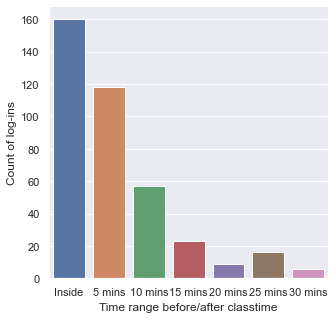

In [65]:
sns.barplot(x='Time range before/after classtime',y='Count of log-ins',data=login_dist_df)
sns.set(rc={"figure.figsize":(1, 5)}) 

Here is the list of instructors with the number of their teaching log-ins during this period:

In [113]:
freq_df = resultfilter_df.groupby(['UsernameInst']).agg({'EventID':'count'})
freq_df.rename(columns={'EventID':'Count'},inplace=True)
freq_df.sort_values(by=['Count'],ascending=False)

,Count
UsernameInst,
mrashid,29
jennifereverett,28
dalespicer,19
aures,18
jacobhale,18
hbarreto,18
cmcclellandmethvin,17
saharsattarzadeh,16
smou,15


Grouped by WeekDay:

In [114]:
freq_df_weekday = resultfilter_df.groupby(['WeekDay']).agg({'EventID':'count'})
freq_df_weekday.rename(columns={'EventID':'Count'},inplace=True)
freq_df_weekday.sort_values(by=['Count'],ascending=False)

,Count
WeekDay,
W,97
R,86
M,81
F,67
T,58


Grouped by Building 1:

In [115]:
freq_df_building1 = resultfilter_df.groupby(['BUILDING1_CODE']).agg({'EventID':'count'})
freq_df_building1.rename(columns={'EventID':'Count'},inplace=True)
freq_df_building1.sort_values(by=['Count'],ascending=False)

,Count
BUILDING1_CODE,
JSC,142
AH,117
EC,47
HH,39
OL,23
GCPA,14
NPRK,4
Tent 1,2
PELR,1


Grouped by Building 1 and Room 1:

In [116]:
freq_df_location = resultfilter_df.groupby(['BUILDING1_CODE','ROOM1']).agg({'EventID':'count'})
freq_df_location.rename(columns={'EventID':'Count'},inplace=True)
freq_df_location

Count
BUILDING1_CODE ROOM1                   
AH             110                    1
               111                   28
               112                   19
               117                   51
               17                     3
               201                    1
               202                    1
               203                    5
               222                    3
               302                    1
               318                    4
EC             020                   47
GCPA           0179                   7
               1021                   5
               1027                   1
               1152                   1
HH             102                   11
               301                   28
JSC            108                   11
               151                   24
               152                   18
               156                    2
               157                    4
               159                   15
               221                   18
               223                    2
               249                    1
               250                    5
               251                   29
               278                    2
               315                    1
               374                   10
NPRK           EFS                    4
OL             241                   20
               AUD                    3
PELR           209                    1
Tent 1         The Inn at DePauw      2

Grouped by Node:

In [117]:
freq_df_node = resultfilter_df.groupby(['Node']).agg({'EventID':'count'})
freq_df_node.rename(columns={'EventID':'Count'},inplace=True)
freq_df_node.sort_values(by=['Count'],ascending=False)

,Count
Node,
VDefaultD-1.depauw.edu,37
VDefaultD-2.depauw.edu,29
VDefaultD-6.depauw.edu,26
VDefaultD-9.depauw.edu,25
VDefaultD-3.depauw.edu,25
VDefaultD-5.depauw.edu,21
VDefaultD-4.depauw.edu,20
VDefaultD-12.depauw.edu,18
VDefaultD-10.depauw.edu,17
